
<h1>
<center>Brazilian E-Commerce Data Analysis</center>
</h1>

<h2>
<center>[Baihui Cao]</center>
</h2>

## **Introduction**

Olist is a Brazilian e-commerce platform that connects small and medium-sized merchants to online marketplaces.

This analysis aims to understand sales growth patterns, product category performance, customer purchasing behavior, and regional differences using historical transaction data. The goal is to identify key revenue drivers and customer retention opportunities that could support business growth and strategic decision-making.

## **Data Preparation**

The dataset contains 100K anonymized Brazilian e-commerce transaction records, including orders, products, payments, customers, and sellers. It covers purchases made between 2016 and 2018 and represents multiple dimensions of the e-commerce business, such as transaction timing, product categories, customer locations, and payment values.

Data from multiple tables were cleaned, exteacted, and integrated using SQL to create a unified analysis dataset (`ecommerce`) at the order-item level, allowing revenue, product category, customer, and regional information to be analyzed together.

Key business metrics were defined as follows:

* Revenue: sum of item-level prices for delivered orders

* Order volume: number of unique orders

* Average Order Value (AOV): total revenue divided by number of orders

* Returning customer: a customer who placed more than one order over the record

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the processed dataset
df = pd.read_csv('ecommerce.csv')
df.head()

,order_id,order_purchase_timestamp,customer_unique_id,customer_state,product_category_name,price,freight_value
0,72bd19ef4fa285334b95bda01a3718c7,2018-05-09 13:01:24,85d234692f7bee8d6fea586e237334b6,SP,esporte_lazer,45.00,17.06
1,760312f5735ee281f01e56d5ddee05e3,2018-06-11 15:32:06,941590fb8aef66b3a8352fe7c691879e,BA,cama_mesa_banho,74.99,25.58
2,760312f5735ee281f01e56d5ddee05e3,2018-06-11 15:32:06,941590fb8aef66b3a8352fe7c691879e,BA,cama_mesa_banho,74.99,25.58
3,0daf1f0e67b534ad873ba61c5d6ad7d3,2017-09-05 10:54:17,84032c13e75382a35c99ae73156b30b9,RJ,cama_mesa_banho,135.00,18.20
4,4a5cc9b4e332e03d76bf553a7f2fa5d3,2017-12-15 23:33:32,94e89532396b3c02f648b2bc7f93f528,RJ,beleza_saude,159.90,16.88


In [2]:
# Date formats for following analysis
df['order_date'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_month'] = df['order_date'].dt.to_period('M')
df.head()

,order_id,order_purchase_timestamp,customer_unique_id,customer_state,product_category_name,price,freight_value,order_date,order_month
0,72bd19ef4fa285334b95bda01a3718c7,2018-05-09 13:01:24,85d234692f7bee8d6fea586e237334b6,SP,esporte_lazer,45.00,17.06,2018-05-09 13:01:24,2018-05
1,760312f5735ee281f01e56d5ddee05e3,2018-06-11 15:32:06,941590fb8aef66b3a8352fe7c691879e,BA,cama_mesa_banho,74.99,25.58,2018-06-11 15:32:06,2018-06
2,760312f5735ee281f01e56d5ddee05e3,2018-06-11 15:32:06,941590fb8aef66b3a8352fe7c691879e,BA,cama_mesa_banho,74.99,25.58,2018-06-11 15:32:06,2018-06
3,0daf1f0e67b534ad873ba61c5d6ad7d3,2017-09-05 10:54:17,84032c13e75382a35c99ae73156b30b9,RJ,cama_mesa_banho,135.00,18.20,2017-09-05 10:54:17,2017-09
4,4a5cc9b4e332e03d76bf553a7f2fa5d3,2017-12-15 23:33:32,94e89532396b3c02f648b2bc7f93f528,RJ,beleza_saude,159.90,16.88,2017-12-15 23:33:32,2017-12


## **Q1. Revenue and Order Volume Trend**

To understand how overall business performance has evolved over time and whether seasonal patterns are present, we use monthly revenue and order volume as metrics.

In [3]:
# Calculate the Monthly Revenue and Order Volume
monthly = (
    df.groupby('order_month')
      .agg(
          revenue=('price', 'sum'),
          order_volume=('order_id', 'nunique') # use number of orders not items
      )
      .reset_index()
)

monthly.head()

,order_month,revenue,order_volume
0,2016-09,134.97,1
1,2016-10,40259.22,263
2,2016-12,10.90,1
3,2017-01,108260.72,739
4,2017-02,225702.29,1603


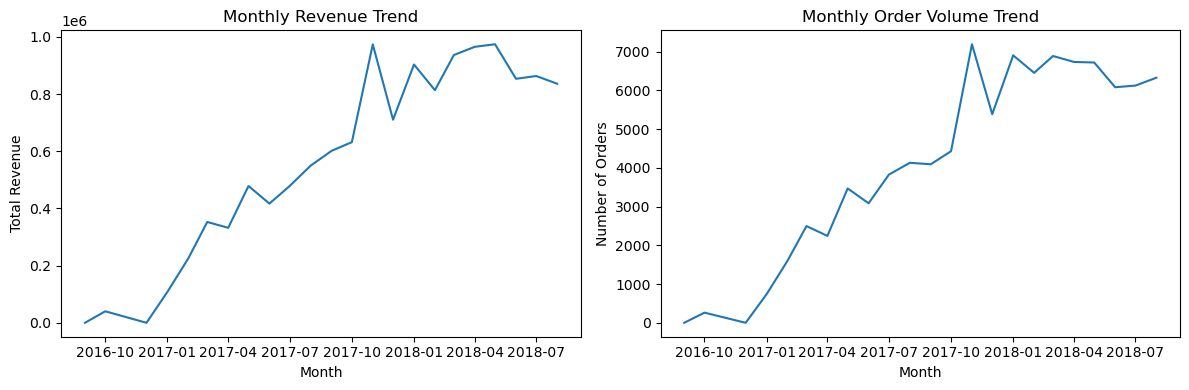

In [4]:
# Plot
monthly['order_month'] = monthly['order_month'].dt.to_timestamp()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Monthly Revenue Trend
axes[0].plot(monthly['order_month'], monthly['revenue'])
axes[0].set_title("Monthly Revenue Trend")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Total Revenue")

# Order Volume Trend
axes[1].plot(monthly['order_month'], monthly['order_volume'])
axes[1].set_title("Monthly Order Volume Trend")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Number of Orders")

plt.tight_layout()
plt.show()

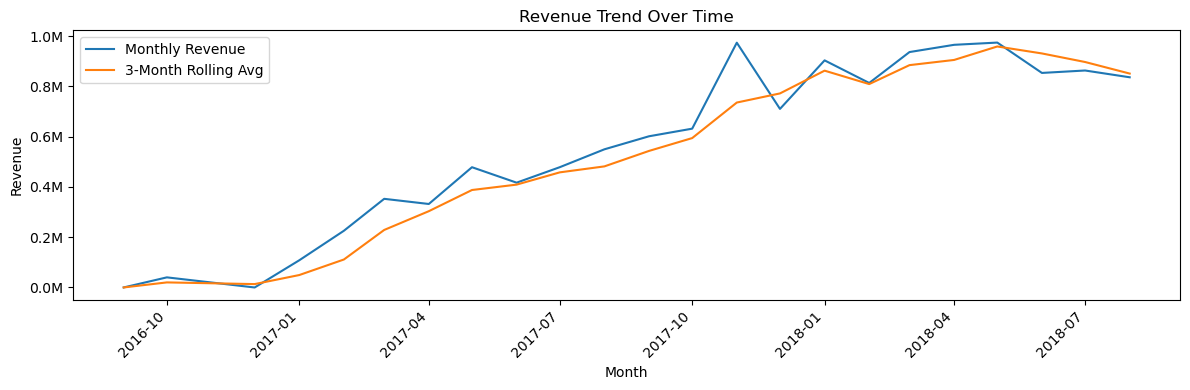

In [5]:
# Plot
import matplotlib.ticker as mtick

def _to_millions(x, pos):
    return f"{x/1e6:.1f}M"

# Monthly Revenue Trend
plt.figure(figsize=(12,4))
plt.plot(monthly['order_month'], monthly['revenue'], label='Monthly Revenue')
plt.plot(
    monthly['order_month'],
    monthly['revenue'].rolling(3, min_periods=1).mean(),
    label='3-Month Rolling Avg'
)
plt.title("Revenue Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(_to_millions))
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

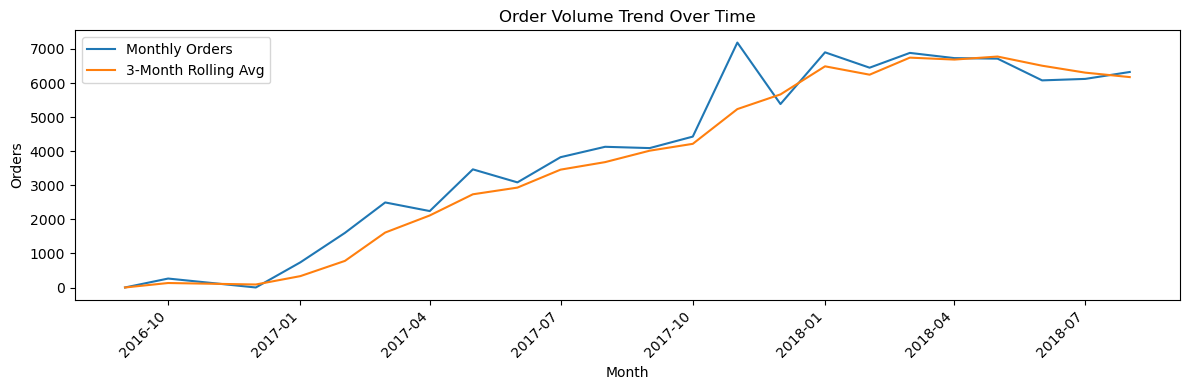

In [6]:
# Order Volume Trend
plt.figure(figsize=(12,4))
plt.plot(monthly['order_month'], monthly['order_volume'], label='Monthly Orders')
plt.plot(
    monthly['order_month'],
    monthly['order_volume'].rolling(3, min_periods=1).mean(),
    label='3-Month Rolling Avg'
)
plt.title("Order Volume Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Orders")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

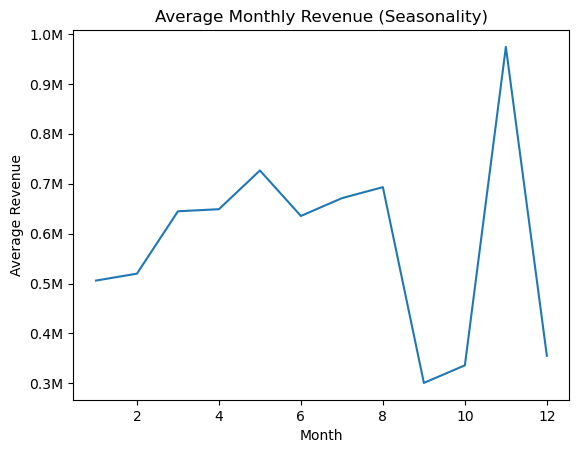

In [7]:
# Seasonality Change
monthly['month'] = monthly['order_month'].dt.month

seasonality = (
    monthly
    .groupby('month')
    .agg(avg_revenue=('revenue', 'mean'))
    .reset_index()
)

plt.figure()
plt.plot(seasonality['month'], seasonality['avg_revenue'])
plt.xlabel("Month")
plt.ylabel("Average Revenue")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(_to_millions))
plt.title("Average Monthly Revenue (Seasonality)")
plt.show()

After visualizing revenue and order volume over time, several patterns emerge:

* Both revenue and order volume show a clear upward trend, indicating sustained business growth during the observed period.

* Revenue growth generally aligns with order volume growth, implying that increased sales are primarily driven by higher transaction counts rather than price inflation.

* Clear seasonal patterns emerged, with higher revenue typically occurring toward the end of the year, suggesting the influence of holiday-related demand.

## **Q2. Product Category Contribution**

Product performance was evaluated by aggregating sales across product categories and comparing total revenue contributions with average order values.

In [8]:
# Drop the products without category
df_cat = df.dropna(subset=['product_category_name'])
df_cat['product_category_name'].value_counts().head(10)

product_category_name
cama_mesa_banho           10953
beleza_saude               9465
esporte_lazer              8431
moveis_decoracao           8160
informatica_acessorios     7644
utilidades_domesticas      6795
relogios_presentes         5859
telefonia                  4430
ferramentas_jardim         4268
automotivo                 4140
Name: count, dtype: int64

In [9]:
# Calculate Average Order Value
category = (
    df_cat
    .groupby('product_category_name')
    .agg(
        total_revenue=('price', 'sum'),
        order_count=('order_id', 'nunique')
    )
    .reset_index()
)

category['aov'] = (
    category['total_revenue'] /
    category['order_count']
)

# Categories Contribute the Most
top_categories = category.sort_values(
    by='total_revenue',
    ascending=False
)

top_categories.head()

,product_category_name,total_revenue,order_count,aov
11,beleza_saude,1233131.72,8647,142.608040
66,relogios_presentes,1166176.98,5495,212.225110
13,cama_mesa_banho,1023434.76,9272,110.379072
32,esporte_lazer,954852.55,7530,126.806448
44,informatica_acessorios,888724.61,6530,136.098715


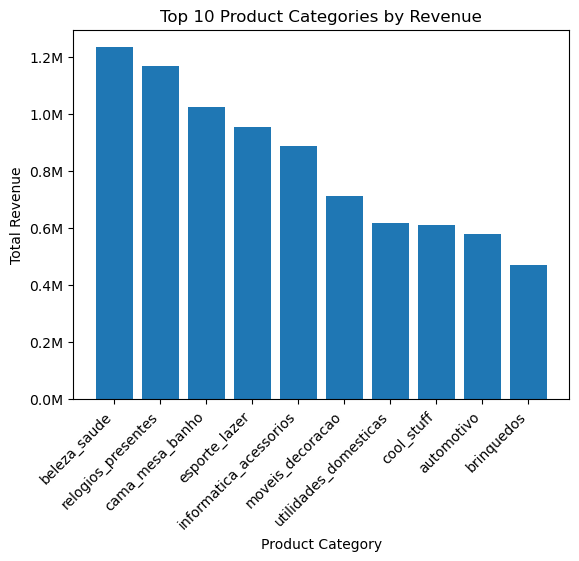

In [10]:
# Plot top 10 contribution
top10 = top_categories.head(10)

plt.figure()
plt.bar(top10['product_category_name'], top10['total_revenue'])
plt.xlabel("Product Category")
plt.ylabel("Total Revenue")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(_to_millions))
plt.title("Top 10 Product Categories by Revenue")
plt.xticks(rotation=45, ha='right')
plt.show()

In [11]:
# Calculate Cumulative Revenue Share
top_categories['revenue_share'] = (
    top_categories['total_revenue'] /
    top_categories['total_revenue'].sum()
)

top_categories['cumulative_share'] = (
    top_categories['revenue_share'].cumsum()
)

top_categories.head()

,product_category_name,total_revenue,order_count,aov,revenue_share,cumulative_share
11,beleza_saude,1233131.72,8647,142.608040,0.094501,0.094501
66,relogios_presentes,1166176.98,5495,212.225110,0.089370,0.183871
13,cama_mesa_banho,1023434.76,9272,110.379072,0.078431,0.262303
32,esporte_lazer,954852.55,7530,126.806448,0.073175,0.335478
44,informatica_acessorios,888724.61,6530,136.098715,0.068108,0.403585


In [12]:
# Find out how many categories contribute to 80% revenue
top_categories[top_categories['cumulative_share'] <= 0.8].shape

(16, 6)

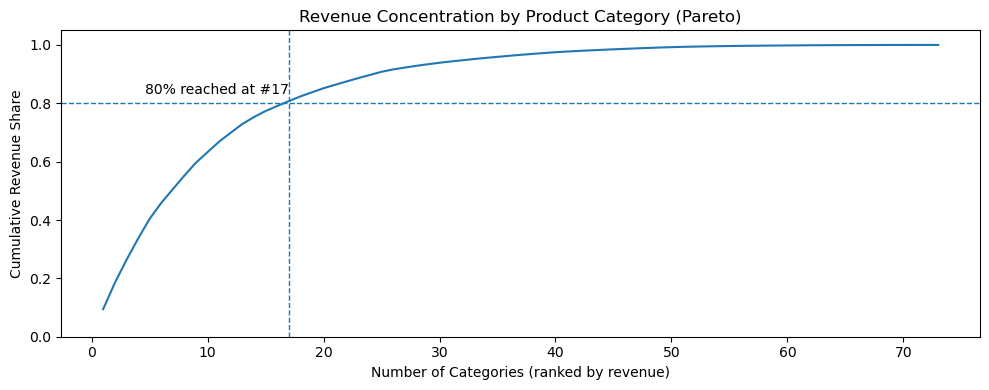

In [13]:
# Cum Share Plot
cum = top_categories['cumulative_share'].values
x = np.arange(1, len(cum) + 1)
k = int(np.argmax(cum >= 0.8) + 1)  # first index reaching 80%

plt.figure(figsize=(10,4))
plt.plot(x, cum)
plt.axhline(0.8, linestyle='--', linewidth=1)
plt.axvline(k, linestyle='--', linewidth=1)
plt.title("Revenue Concentration by Product Category (Pareto)")
plt.xlabel("Number of Categories (ranked by revenue)")
plt.ylabel("Cumulative Revenue Share")
plt.ylim(0, 1.05)

plt.text(k, 0.82, f"80% reached at #{k}", ha='right', va='bottom')
plt.tight_layout()
plt.show()

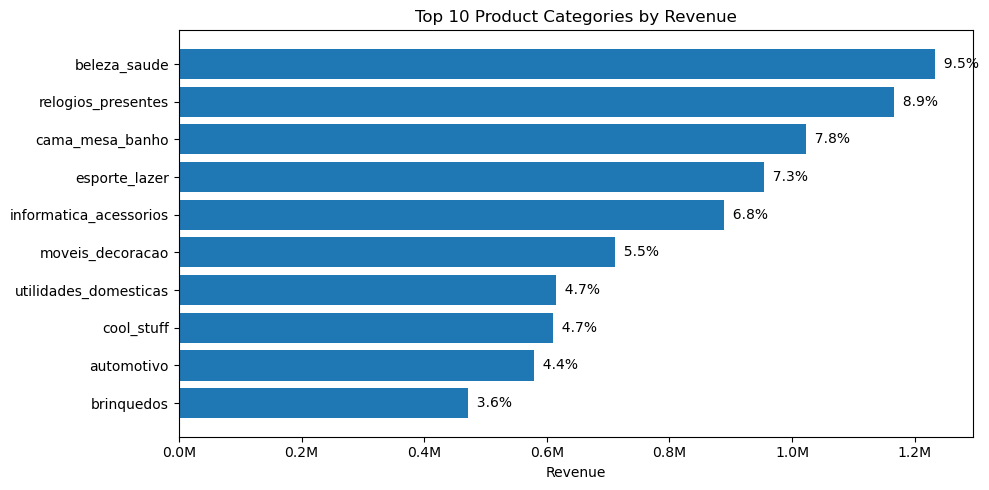

In [14]:
# Horizontal Bar Chart
top10 = top_categories.head(10).sort_values('total_revenue', ascending=True)  # for barh bottom->top

plt.figure(figsize=(10,5))
plt.barh(top10['product_category_name'], top10['total_revenue'])
plt.title("Top 10 Product Categories by Revenue")
plt.xlabel("Revenue")
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(_to_millions))

# annotate share %
for y, (v, s) in enumerate(zip(top10['total_revenue'], top10['revenue_share'])):
    plt.text(v, y, f"  {s:.1%}", va='center')

plt.tight_layout()
plt.show()

The analysis reveals a highly uneven distribution of revenue across product categories:

* Revenue is highly concentrated, with a relatively small number of product categories accounting for a large share of total sales (Top 16 categories covers 80% revenue).

* Categories such as health beauty (`beleza_saude`) and watches gifts (`relogios_presentes`) consistently rank among the top revenue contributors.

* Long-tail categories account for a small fraction of revenue, suggesting potential for inventory optimization or targeted marketing campaigns.

## **Q3. New and Returning Customers Behavior**

To better understand customer purchasing behavior, we compared order patterns and spending between new and returning customers.

In [15]:
# Create Order-level Dataframe 
orders_df = (
    df.groupby(['order_id', 'customer_unique_id'], as_index=False)
      .agg(
          order_date=('order_date', 'min'), # order with multiple items: keep single timestamp
          order_revenue=('price', 'sum')   # order value = sum(item_price)
      )
)
orders_df.head()

,order_id,customer_unique_id,order_date,order_revenue
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,58.90
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,239.90
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,199.00
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,199.90


In [16]:
# Mark the First Order Day
first_order = (
    orders_df.groupby('customer_unique_id')['order_date']
          .min()
          .reset_index(name='first_order_date')
)

orders_df = orders_df.merge(
    first_order,
    on='customer_unique_id',
    how='left'
)

# Define New and Returning Customers
orders_df['customer_type'] = orders_df.apply(
    lambda x: 'New' if x['order_date'] == x['first_order_date'] else 'Returning',
    axis=1
)
orders_df.head()

,order_id,customer_unique_id,order_date,order_revenue,first_order_date,customer_type
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,58.90,2017-09-13 08:59:02,New
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,239.90,2017-04-26 10:53:06,New
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,199.00,2018-01-14 14:33:31,New
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,12.99,2018-08-08 10:00:35,New
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 13:57:51,199.90,2017-02-04 13:57:51,New


In [17]:
# Behavior Differ
customer_type = (
    orders_df.groupby('customer_type')
          .agg(
              total_revenue=('order_revenue', 'sum'),
              order_count=('order_id', 'nunique')
          )
          .reset_index()
)

customer_type['aov'] = (
    customer_type['total_revenue'] /
    customer_type['order_count']
)

customer_type['revenue_share'] = (
    customer_type['total_revenue'] / 
    customer_type['total_revenue'].sum()
)

customer_type.head()

,customer_type,total_revenue,order_count,aov,revenue_share
0,New,12697081.37,92345,137.496143,0.973043
1,Returning,351756.11,2800,125.627182,0.026957


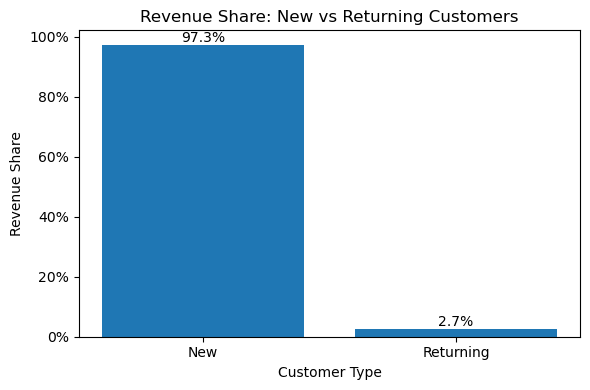

In [18]:
# Revenue Share Plot
plt.figure(figsize=(6,4))
plt.bar(customer_type['customer_type'], customer_type['revenue_share'])
plt.title("Revenue Share: New vs Returning Customers")
plt.xlabel("Customer Type")
plt.ylabel("Revenue Share")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for x, v in enumerate(customer_type['revenue_share']):
    plt.text(x, v, f"{v:.1%}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

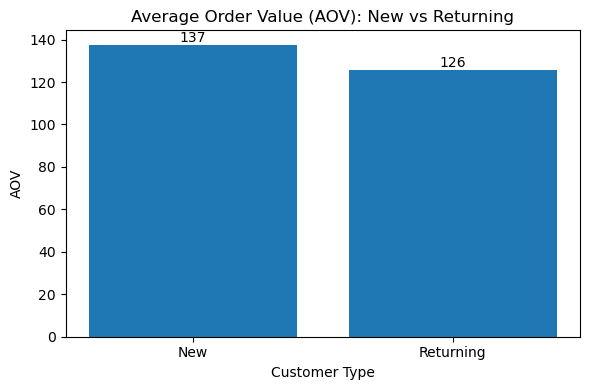

In [19]:
# AOV Plot
plt.figure(figsize=(6,4))
plt.bar(customer_type['customer_type'], customer_type['aov'])
plt.title("Average Order Value (AOV): New vs Returning")
plt.xlabel("Customer Type")
plt.ylabel("AOV")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

for x, v in enumerate(customer_type['aov']):
    plt.text(x, v, f"{v:,.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

Based on the plot of Revenue Contribution and AOV between new and returning customers, we can see:

* Revenue is overwhelmingly driven by new customers, indicating that the platform’s sales performance is primarily acquisition-driven, with the majority of customers completing only a single purchase.

* New customers exhibit slightly higher average order values than returning customers, suggesting that first-time purchases tend to be higher-value transactions, while subsequent purchases are typically smaller and more incremental.

* Returning customers contribute a relatively small share of total revenue, highlighting an opportunity to improve customer retention and long-term customer value through targeted post-purchase engagement strategies.

## **Q4. Repeat Purchase Rate**

Given the low revenue contribution from returning customers, the next step is to examine repeat purchase rates and how quickly customers return after their first purchase.

In [20]:
# Mark Returning Customers
orders_per_customer = (
    orders_df.groupby('customer_unique_id')['order_id']
          .nunique()
          .reset_index(name='num_orders') # based on orders not items
)

# Calculate the Repeat Purchase Rate
repeat_purchase_rate = (orders_per_customer['num_orders'] >= 2).mean()
print(f"Repeat Purchase Rate: {repeat_purchase_rate:.2%}")

Repeat Purchase Rate: 2.98%


In [21]:
# Time that Customer Return
customer_order_times = (
    orders_df.sort_values(['customer_unique_id', 'order_date'])
          .groupby('customer_unique_id')['order_date']
          .apply(list)
          .reset_index(name='order_times')
)

customer_order_times['days_to_second_order'] = customer_order_times['order_times'].apply(
    lambda x: (x[1] - x[0]).days if len(x) >= 2 else None
)
customer_order_times.head()

,customer_unique_id,order_times,days_to_second_order
0,0000366f3b9a7992bf8c76cfdf3221e2,[2018-05-10 10:56:27],NaN
1,0000b849f77a49e4a4ce2b2a4ca5be3f,[2018-05-07 11:11:27],NaN
2,0000f46a3911fa3c0805444483337064,[2017-03-10 21:05:03],NaN
3,0000f6ccb0745a6a4b88665a16c9f078,[2017-10-12 20:29:41],NaN
4,0004aac84e0df4da2b147fca70cf8255,[2017-11-14 19:45:42],NaN


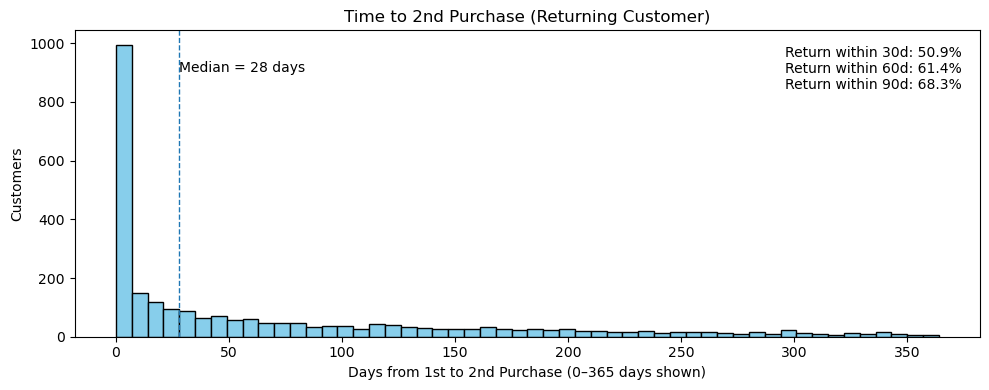

In [22]:
second_order_days = customer_order_times['days_to_second_order'].dropna()

# Focus on 1 year window
within_365 = second_order_days[second_order_days <= 365]

p30 = (second_order_days <= 30).mean()
p60 = (second_order_days <= 60).mean()
p90 = (second_order_days <= 90).mean()
med = float(np.median(second_order_days))

plt.figure(figsize=(10,4))
plt.hist(within_365, bins=52, color='skyblue', edgecolor='black')  # weekly-ish bins
plt.axvline(med, linestyle='--', linewidth=1)
plt.title("Time to 2nd Purchase (Returning Customer)")
plt.xlabel("Days from 1st to 2nd Purchase (0–365 days shown)")
plt.ylabel("Customers")

plt.text(med, plt.ylim()[1]*0.9, f"Median = {med:.0f} days", ha='left', va='top')
plt.text(0.98, 0.95,
         f"Return within 30d: {p30:.1%}\nReturn within 60d: {p60:.1%}\nReturn within 90d: {p90:.1%}",
         transform=plt.gca().transAxes, ha='right', va='top')

plt.tight_layout()
plt.show()

In [23]:
print("Median days to second purchase:", second_order_days.median())
print("Mean days to second purchase:", second_order_days.mean())

Median days to second purchase: 28.0
Mean days to second purchase: 80.73340627279359


The repeat purchase analysis shows:

* Approximately 2.98% of customers make a second purchase, suggesting significant room to improve customer retention.

* The median time to second purchase is 28 days, with the majority of returning customers placing their next order within a relatively short period, indicating a critical window for re-engagement.

* Insights from repeat purchase timing can inform marketing campaigns, such as personalized reminders or promotions to encourage faster repeat purchases.

## **Q5. Regional Differences in Sales Performance**

Sales metrics were aggregated by customer state to compare total revenue, order volume, and average order value across regions.

In [24]:
region = (
    df.groupby('customer_state')
    .agg(
        total_revenue=('price', 'sum'),
        order_count=('order_id', 'nunique')
    )
    .reset_index()
)

region = region.sort_values(
    by='total_revenue',
    ascending=False
)

region['AOV'] = (
    region['total_revenue'] /
    region['order_count']
)

region['revenue_share'] = (
    region['total_revenue'] /
    region['total_revenue'].sum()
)

region.head(10)

,customer_state,total_revenue,order_count,AOV,revenue_share
25,SP,5004752.07,39963,125.234644,0.383540
18,RJ,1736924.95,12168,142.745311,0.133110
10,MG,1534496.09,11190,137.131018,0.117596
22,RS,719067.86,5269,136.471410,0.055106
17,PR,657744.28,4855,135.477710,0.050406
23,SC,500030.47,3491,143.234165,0.038320
4,BA,487660.19,3215,151.682796,0.037372
6,DF,293919.59,2050,143.375410,0.022525
8,GO,274306.59,1911,143.540863,0.021022
7,ES,267029.18,1978,134.999585,0.020464


The regional analysis highlights substantial disparities across states:

* Revenue is heavily concentrated geographically, with São Paulo (SP) contributing nearly 40% of total sales, making it the primary driver of overall business performance.

* Top regions generate revenue mainly through high order volume rather than higher AOV, while several smaller states show stronger per-order spending despite lower transaction counts.

* This imbalance suggests growth opportunities in mid-tier regions by increasing customer engagement and order frequency, while also highlighting potential risk from over-reliance on a single dominant market.

## **Takeaway**

This analysis highlights that business growth is driven primarily by increasing order volume, with revenue concentrated in a small number of product categories and regions. While new customers contribute the majority of sales, returning customers demonstrate higher order values, underscoring the importance of customer retention. Together, these insights suggest opportunities to optimize category focus, improve retention strategies, and tailor regional approaches to support sustainable growth.